In [16]:
'''
Machine learning for the 1D beam finite element
Last Updated : 04/02/2019, by Hyungmin Jun (hyungminjun@outlook.com)

=============================================================================

Copyright 2019 Hyungmin Jun. All rights reserved.

License - GPL version 3
This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or any later version. This
program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
'''

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv

from keras.models import Sequential
from keras.layers import Dense
from numpy.linalg import inv

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

%matplotlib inline

np.random.seed(1)

In [17]:
# Stiffness matrix for the beam finite element
def Stiffness_Beam(n_nde):
    
    # Define sectional and material properties
    L = 1000          # m
    E = 210000        # N/m**2
    I = 0.801*10**6   # m**4

    # The number of elements
    n_ele = n_nde - 1
    
    # The number of degrees of freedom
    n_dof = n_nde * 2    
    
    # Element stiffness matrix
    L_e = L / n_ele
    K_e = E*I/L_e**3 * np.matrix([
        [  12,     -6*L_e,    -12,     -6*L_e],
        [  -6*L_e,  4*L_e**2,   6*L_e,  2*L_e**2],
        [ -12,      6*L_e,     12,      6*L_e],
        [  -6*L_e,  2*L_e**2,   6*L_e,  4*L_e**2]])
    
    # Assemble stiffness matrix
    K_mat = np.zeros([n_dof, n_dof])
    for i in range(n_ele):
        K_mat[2*i:2*i+4, 2*i:2*i+4] += K_e
    
    return K_mat

In [18]:
# External force vector
def R_vec(n_dof):
    load = 1000*(np.random.random(n_nde)*2-1)
    
    # Force vector
    R = np.zeros(n_dof)
    R[0::2] = load
    return R[2:]

In [19]:
n_nde = 100
n_dof = 2*n_nde
K_mat = Stiffness_Beam(n_nde)

# Impose boundary conditions
K_mat = K_mat[2:, 2:]

# Inverse stiffness matrix
K_inv = inv(K_mat)

# Make force vector set
n_set = 20000
U_set = np.zeros([n_set, n_nde])
R_set = np.zeros([n_set, n_nde - 1])

for i in range(n_set):
    R = R_vec(n_dof)
    U = np.matmul(K_inv, R)
    
    v = U[0::2]
    v = np.insert(v, 0, 0)
    U_set[i, :] = v
    R_set[i, :] = R[0::2]

In [20]:
# Set train and test set using sklearn library
x_train, x_test, y_train, y_test = train_test_split(R_set/10000, U_set, test_size=0.2, random_state=1)

# Set train and test set with the ratio 8:2 manually
#x_train = R_set[0:int(n_set*0.8), :]*1/10000
#y_train = U_set[0:int(n_set*0.8), :]
#x_test  = R_set[int(n_set*0.8):, :]*1/10000
#y_test  = U_set[int(n_set*0.8):, :]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((16000, 99), (4000, 99), (16000, 100), (4000, 100))

In [21]:
# Set the train model
model = Sequential()

model.add(Dense(128, activation='tanh', input_shape=(n_nde-1,)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(n_nde, activation='linear'))

model.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
model.summary()

# Train the model
#hist = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data = (x_test, y_test))
hist = model.fit(x_train, y_train, epochs=50, verbose=1, validation_split = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               12800     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6500      
Total params: 27,556
Trainable params: 27,556
Non-trainable params: 0
_________________________________________________________________
Train on 12800 samples, validate on 3200 samples
Epoch 1/50
12800/12800 [==============================] - 1s 57us/step - loss: 1.5959 - acc: 0.4073 - val_loss: 0.1057 - val_acc: 0.5191
Epoch 2/50
12800/12800 [==============================] - 0s 35us/step - loss: 0.0721 - acc: 0.5045 - val_loss: 0.0579 - val_acc: 0.4947
Epoch 3/50
12800/12800 [==============================] - 0s 34us/step - loss: 

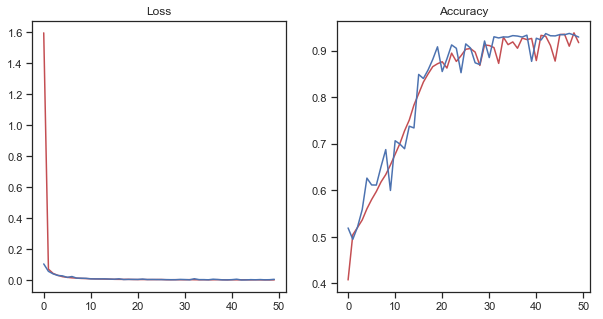

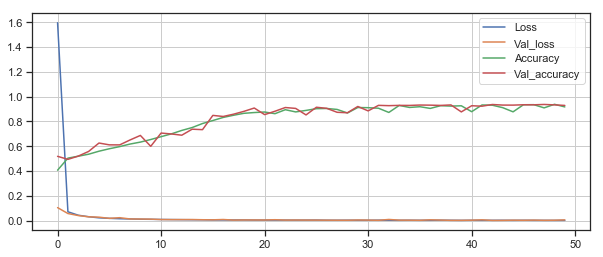

In [22]:
#print(hist)
#print(model.get_weights())

sns.set(style="ticks", color_codes=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'], color='b')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], color='r')
plt.plot(hist.history['val_acc'], color='b')
plt.title('Accuracy')

plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Loss','Val_loss', 'Accuracy','Val_accuracy'])
plt.grid()

In [23]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy = {:.2f}".format(accuracy))
print("Loss = {:.2f}".format(loss))

4000/4000 [==============================] - 0s 17us/step
Accuracy = 0.94
Loss = 0.01


In [24]:
# Predict with test data set
pred_test = model.predict(x_test)

# Predict with the value
# Define point load
F     = np.zeros(n_dof - 2)
F[-2] = -10000

# Find reference solution
d  = np.matmul(inv(K_mat), F)
dz = d[0::2]
dz = np.insert(dz, 0, 0)

f    = F[0::2]*1/10000
pred = model.predict(np.reshape(f, (1, len(f))))

Text(0.5, 1.0, 'Predict with the value')

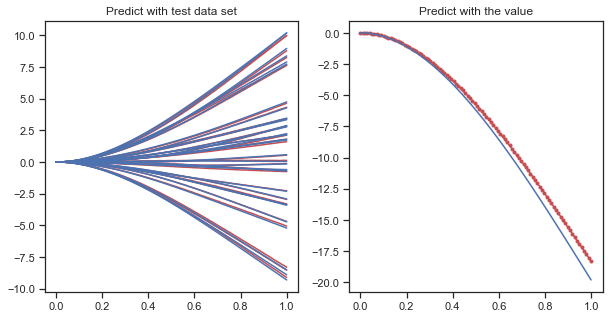

In [25]:
x = np.linspace(0, 1, n_nde)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, np.transpose(pred_test[0:30, :]), color='r')
plt.plot(x, np.transpose(y_test[0:30, :]), color='b')
plt.title('Predict with test data set')

plt.subplot(1, 2, 2)
plt.plot(x, pred[0], color='r', marker='o', markersize=3)
plt.plot(x, dz, color='b')
plt.title('Predict with the value')